In [1]:
import numpy as np
from google.colab import drive
from numpy import loadtxt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from scipy.stats import randint
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [2]:
drive.mount('/content/drive')

with open('/content/drive/My Drive/Comp Sci 539/data/weather_prediction_dataset.csv', 'r') as f:
    tmp = np.genfromtxt(f, delimiter=',')
    data = tmp[~np.isnan(tmp).any(axis=1), :]
    X = data[:,1:11]
    X = np.delete(X,5,1)
    y = data[:, 6]
    y = y >= 0.15

Mounted at /content/drive


In [3]:
if np.sum(np.isnan(X)):
  print("Total NaN before imputation: ", np.sum(np.isnan(X)))
  imputer = KNNImputer(n_neighbors=2, weights="uniform")
  X1 = imputer.fit_transform(X)
  print("Total NaN after imputation: ", np.sum(np.isnan(X1)))
else:
  X1 = X
  print("No NaN")

No NaN


In [4]:
seed = 7
test_size = 0.8
X_train, X_main, y_train, y_main = train_test_split(X1, y, test_size = test_size, random_state = seed)
X_val, X_test, y_val, y_test = train_test_split(X_main, y_main, test_size = 0.5, random_state = seed)

In [5]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)

In [6]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=50, oob_score=True)
clf = clf.fit(X_train, y_train)

print(clf.get_params)

<bound method BaseEstimator.get_params of RandomForestClassifier(n_estimators=50, oob_score=True)>


In [7]:
y_hat = clf.predict(X_val)

In [8]:
from sklearn.metrics import confusion_matrix

Cmat = confusion_matrix(y_val, y_hat)
acc = clf.score(X_val,y_val)

print("Confusion Matrix: ")
print(Cmat)
print("Accuracy: " + str(acc*100) + '%')

Confusion Matrix: 
[[929 118]
 [188 227]]
Accuracy: 79.06976744186046%


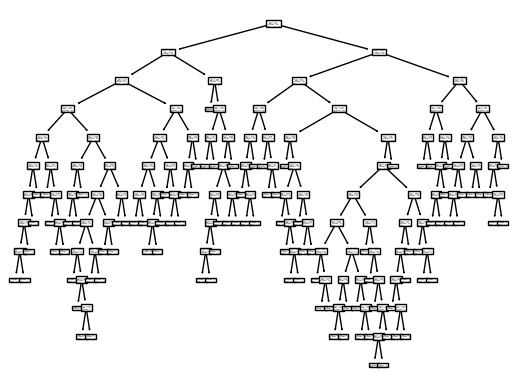

In [9]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
plot_tree(clf.estimators_[0])
plt.show()

In [10]:
min_estimators = 1
max_estimators = 100
error_rate = []

for i in range(min_estimators, max_estimators + 1):
  clf.set_params(n_estimators=i)
  clf.fit(X_val, y_val)
  # Record the OOB error for each `n_estimators=i` setting.
  oob_error = 1 - clf.oob_score_
  error_rate.append(oob_error)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too fe

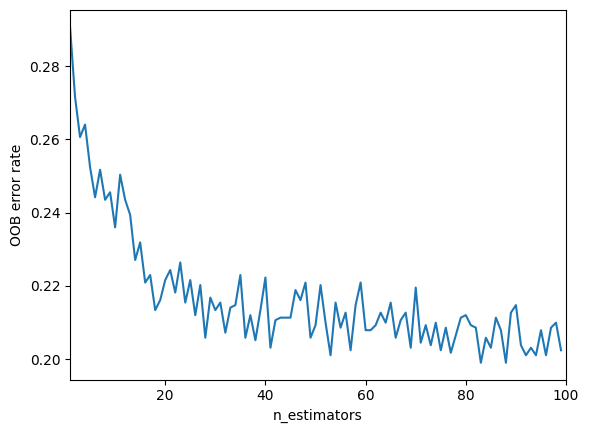

In [11]:
plt.plot(error_rate)
plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.show()

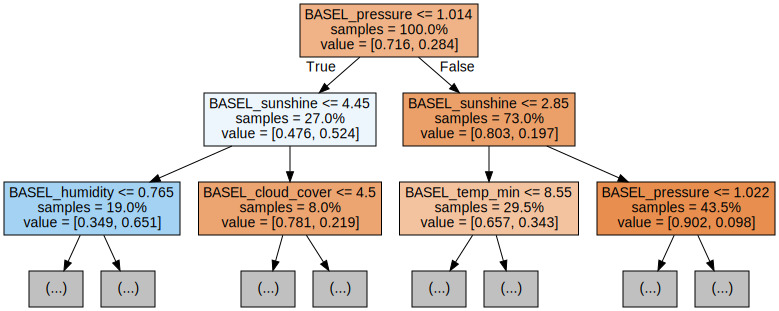

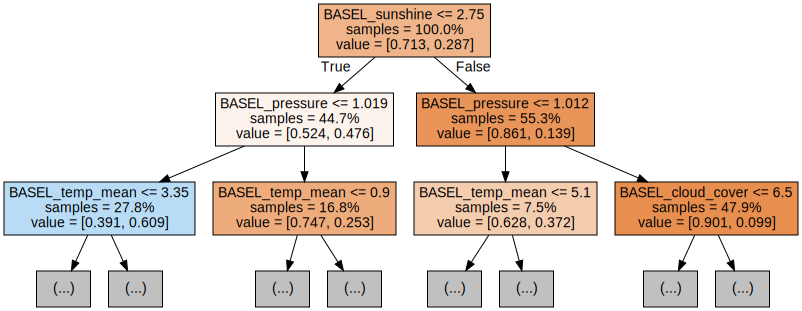

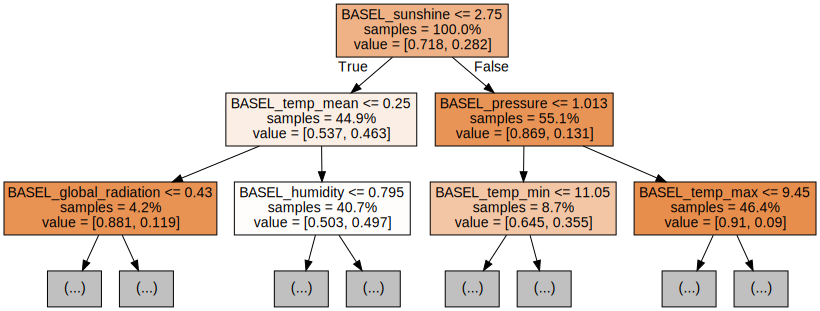

In [12]:
# Export the first three decision trees from the forest
features = 'DATE','BASEL_cloud_cover', 'BASEL_humidity', 'BASEL_pressure', 'BASEL_global_radiation', 'BASEL_sunshine', 'BASEL_temp_mean','BASEL_temp_min', 'BASEL_temp_max'
for i in range(3):
    tree = clf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=features,
                               filled=True,
                               max_depth=2,
                               impurity=False,
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

In [13]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
new_clf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(new_clf,
                                 param_distributions = param_dist,
                                 n_iter=5,
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x793df7e096f0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x793df7b90940>})

In [14]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 17, 'n_estimators': 397}


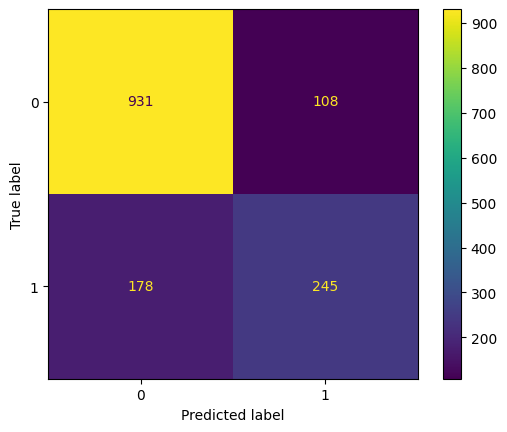

In [15]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [16]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.8043775649794802
Precision: 0.6940509915014165
Recall: 0.5791962174940898
